In [1]:
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from config import config
from data_handling import unpickle, label_names_extraction 
from image_feature_extraction import load_images, even_instances
import matplotlib.pyplot as plt
import os
%matplotlib inline

#### Note - dataset normalized vs. non-normalized
In the report, one can see the results coming from a normalized and not normalized data (before feeding to the neural network). The variable that controls it here is dataset_normalized. If one needs to read in the non-normalized version, just set it to false here or in a config.ini file. However, this assumes that the data is already generated. To generate non-normalized data, one should run a python script cnn_codes.py after changing the value in config.ini file. 
<br>
In this report, only values for normalized data will be presented. The importance of data normalization has been mentioned in the report. 

In [2]:
dataset_normalized = config['dataset_details']['network_normalized']
path_restricted_dataset = config['paths']['restricted_dataset_path']
if dataset_normalized:
    path_features_network = config['paths']['network_representations']
else: 
    path_features_network = config['paths']['network_representations'] + "_not_normalized"
content_features_network = unpickle(path_features_network)
meta_classes = label_names_extraction(os.path.join(path_restricted_dataset, config['dataset_details']['class_info']))


#original with labels
train_data = content_features_network['train']
train_labels = content_features_network['train_labels']
test_data = content_features_network['test']
test_labels = content_features_network['test_labels']

In [3]:
#map train labels
mapped_train_labels = [meta_classes[x] for x in train_labels]
mapped_test_labels = [meta_classes[x] for x in test_labels]

### Visualization of CNN Codes
Here, I will visualize the features of CNN projected into two dimensions. I will use two dimensionality reduction techniques: PCA and TSNE (the first one, since it is standard and the second one, as it is also a common practice in CNNs, e.g. here: https://cs.stanford.edu/people/karpathy/cnnembed/).
<br>
Furthermore, I will explore how much variance is explained by the two dimensions of PCA.

In [4]:
def reduce_dimensionality(input_data, n_dim, mode):
    if mode=='tsne':
        reducer = TSNE(n_components=n_dim, random_state=42, verbose=1)
    if mode=='pca':
        reducer = PCA(n_components=n_dim, random_state=42)
        x = reducer.fit(input_data)
        print("Explained variance ratio for PCA:", np.sum(x.explained_variance_ratio_))
    reduced_data = reducer.fit_transform(input_data)
    if mode=='tsne':
        print("KL divergence: {}".format(reducer.kl_divergence_))
    return reduced_data

def visualize_results(data, labels, class_names, mode, n_dim=2, colors=None, reduce=False, limits=False):
    if reduce:
        viz_data = reduce_dimensionality(data, n_dim, mode)
    else:
        viz_data = data
    if colors==None:
        colors = {x: np.random.rand(3,1) for x in class_names.keys()}
    plt.figure(figsize=(13,9))
    for label in class_names.keys():
        ind = np.where(labels == label)[0]
        plt.scatter(viz_data[ind,0], viz_data[ind,1], label=class_names[label], color=colors[label][:,0])
    plt.legend(class_names.values(), mode='expand', ncol=10)
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.title(mode)
    plt.grid()
    plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data)
colors = {x: np.random.rand(3,1) for x in meta_classes.keys()}

pca_data = reduce_dimensionality(scaled_data, 2, 'pca')

Explained variance ratio for PCA: 0.07949336220180946


### PCA Visualization

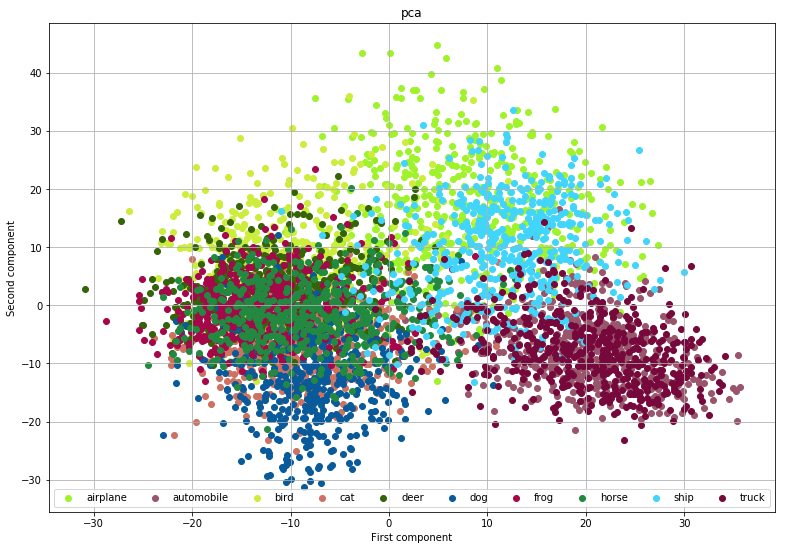

In [6]:
visualize_results(pca_data, train_labels, meta_classes, 'pca', colors=colors)

### tSNE visualization

In [7]:
tsne_data = reduce_dimensionality(scaled_data, 2, 'tsne')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 1.775s...
[t-SNE] Computed neighbors for 5000 samples in 128.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 14.852399
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.070854
[t-SNE] Error after 1000 iterations: 2.622990
KL divergence: 2.6229896545410156


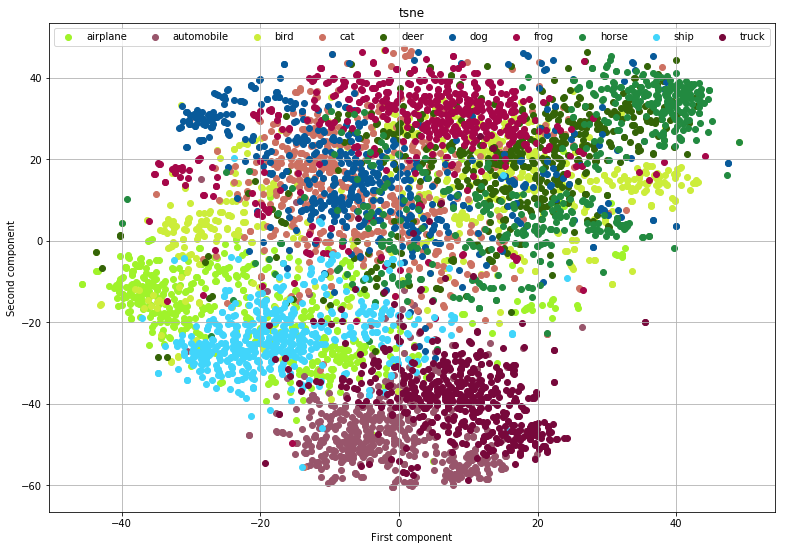

In [8]:
visualize_results(tsne_data, train_labels, meta_classes, mode='tsne', colors=colors)

### Train the SVM classifier on top of the CNN Codes
In this exercise, I will train the classifier on top of the retrieved CNN Codes. Since I have access to limited computing resources, I will use only linear kernel and check 3 values for gamma and C. Of course, the parameters could be further tuned. A grid search is method that exhaustively tries out different parameters to find those that lead to the best score on during the evaluation phase. Nevertheless, it is not a perfect method for finding parameters. Other methods for parameter selection include e.g. Randomized Search (that does not explore all of the values, but rather a sample of them according to a specified distribution) (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). The Grid Search in this assignment is optimized for the accuracy score (mean accuracy over all classes) 

In [9]:
###FINAL CLASSIFICATION
#1.5hours run without GPU; with GPU - about 15-20 minutes
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import time

def parameter_tuning_svm(params, data, labels, cv=5, n_jobs=7):
    svm = SVC(kernel='linear')
    gridsearch = GridSearchCV(svm, params, cv=cv, n_jobs=n_jobs, scoring='accuracy', verbose=1)
    gridsearch.fit(data, labels)
    best_params = gridsearch.best_params_
    best_score = gridsearch.best_score_
    print("Best parameters: {}".format(best_params))
    print("Best performance: {}".format(best_score))
    return best_params, best_score

parameters = {'gamma': [1e-1,1e-3, 1e-5],'C': [1, 10, 100]}
params,score = parameter_tuning_svm(parameters, scaled_data, train_labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed: 13.3min finished


Best parameters: {'C': 1, 'gamma': 0.1}
Best performance: 0.7986


In [10]:
print("Printing parameters to further use them in the experiment 2")
print(params)

Printing parameters to further use them in the experiment 2
{'C': 1, 'gamma': 0.1}


In [11]:
#final prediction
def evaluate_classifier(clf, train_data, train_labels, test_data, test_labels):
    clf.fit(train_data, train_labels)
    pred = clf.predict(test_data)
    print(classification_report(test_labels, pred))
    print("Average accuracy: {}".format(accuracy_score(test_labels, pred)))
    return pred 


clf = SVC(kernel='linear', gamma=params['gamma'], C=params['C'])
scaled_test_data = scaler.transform(test_data)
preds = evaluate_classifier(clf, scaled_data, train_labels, scaled_test_data, test_labels)

             precision    recall  f1-score   support

          0       0.80      0.79      0.79       100
          1       0.89      0.90      0.90       100
          2       0.71      0.73      0.72       100
          3       0.63      0.70      0.66       100
          4       0.69      0.72      0.70       100
          5       0.78      0.73      0.75       100
          6       0.85      0.83      0.84       100
          7       0.83      0.78      0.80       100
          8       0.89      0.89      0.89       100
          9       0.87      0.83      0.85       100

avg / total       0.79      0.79      0.79      1000

Average accuracy: 0.79


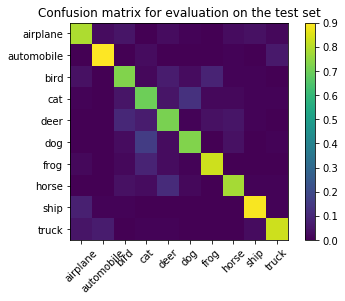

In [12]:
from sklearn.metrics import confusion_matrix
class_names = [meta_classes[i] for i in meta_classes.keys()]
conf_matrix = confusion_matrix(test_labels, preds)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.title("Confusion matrix for evaluation on the test set")
plt.imshow(conf_matrix/np.sum(conf_matrix, axis=1))
plt.colorbar()

The results of the classification process are described in details in the report. 

#### tSNE classifier
Below, I will aim to figure out if the vector resulting from tSNE dimensionality reduction performed on the training set gives satisfying results. For tis classifier, I will also perform a Grid Search - since the data has only 2 dimensions, it is not too computationally expensive.

In [13]:
#check for tsne
tsne_test_data = reduce_dimensionality(scaled_test_data, 2, 'tsne')
tsne_params,tsne_score = parameter_tuning_svm(parameters, tsne_data, train_labels)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.182s...
[t-SNE] Computed neighbors for 1000 samples in 5.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 17.117104
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.875397
[t-SNE] Error after 1000 iterations: 1.746550
KL divergence: 1.74655020236969
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed: 13.8min finished


Best parameters: {'C': 100, 'gamma': 0.1}
Best performance: 0.5148


In [14]:
tsne_clf = SVC(kernel='linear', C=tsne_params["C"], gamma=tsne_params["gamma"])
tsne_preds = evaluate_classifier(tsne_clf, tsne_data, train_labels, tsne_test_data, test_labels)

             precision    recall  f1-score   support

          0       0.05      0.11      0.07       100
          1       0.00      0.00      0.00       100
          2       0.12      0.17      0.14       100
          3       0.07      0.16      0.10       100
          4       0.00      0.00      0.00       100
          5       0.31      0.04      0.07       100
          6       0.00      0.00      0.00       100
          7       0.18      0.57      0.27       100
          8       0.12      0.01      0.02       100
          9       0.00      0.00      0.00       100

avg / total       0.08      0.11      0.07      1000

Average accuracy: 0.106


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
